# <u>`Project 5 Part 1 Core`
* Authored By: Eric N. Valdez
* Date: 2/29/24

# <u><center> [Metabolic Syndrome Prediction](https://data.world/informatics-edu/metabolic-syndrome-prediction)
* The dataset for analysis came from the [NHANES](https://www.cdc.gov/nchs/nhanes/index.htm) initiative where the following variables were combined from multiple tables with SQL: abnormal waist circumference, triglycerides above 150, HDL cholesterol below 50 in women or 40 in men, history of hypertension and mildly elevated fasting blood sugar (100-125). Numerous other variables were added, such as uric acid, race, income, etc. that might contribute to the model but we will not sure, until we test the model.
* [Data Dictionary](https://docs.google.com/document/d/11D8SRng4m7w3ONQkX0bm6_3etsyjD7CDJCNZBLtprzk) as listed below

# <u>Assignment:

#### When choosing your dataset, consider the following:
* What is the target? (You are required to complete a classification task for this project)
* What does one row represent? (A person? A business? An event? A product?)
* How many features does the data have?
* How many rows are in the dataset?
* What opportunities exist for dimensionality reduction or feature selection with this dataset?
* What, if any, challenges do you foresee in cleaning, exploring, or modeling this dataset?

# <u>For this task:
* [Metabolic Syndrome Prediction - dataset by informatics-edu](https://data.world/informatics-edu/metabolic-syndrome-prediction)

# <u>Imports:

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import missingno

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, ConfusionMatrixDisplay, PrecisionRecallDisplay, 
                              f1_score, accuracy_score, precision_score, recall_score, classification_report)
from sklearn.compose import ColumnTransformer, make_column_selector,make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

pd.set_option('display.max_columns',200)
pd.set_option("display.max_info_rows", 800)
pd.set_option('display.max_info_columns',800)

from sklearn import set_config
set_config(transform_output='pandas')

import warnings
warnings.filterwarnings("ignore")

# <u> Custom Functions:

In [2]:
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
    # Get the classification report
    report = classification_report(y_true, y_pred)
    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)
    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    # create a confusion matrix  of raw counts
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
    axes[0].set_title("Raw Counts")
    # create a confusion matrix with the test data
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
    axes[1].set_title("Normalized Confusion Matrix")
    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()
    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return report_dict

In [3]:
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
    # Get predictions for training data
    y_train_pred = model.predict(X_train)
    # Call the helper function to obtain regression metrics for training data
    results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
    print()
    # Get predictions for test data
    y_test_pred = model.predict(X_test)
    # Call the helper function to obtain regression metrics for test data
    results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
    if output_dict == True:
        # Store results in a dataframe if ouput_frame is True
        results_dict = {'train':results_train,
                    'test': results_test}
        return results_dict

In [4]:
def get_importances(model, feature_names=None,name='Feature Importance',
                   sort=False, ascending=True):
    
    ## checking for feature names
    if feature_names == None:
        feature_names = model.feature_names_in_
        
    ## Saving the feature importances
    importances = pd.Series(model.feature_importances_, index= feature_names,
                           name=name)
    
    # sort importances
    if sort == True:
        importances = importances.sort_values(ascending=ascending)
        
    return importances

In [5]:
def plot_importance(importances, top_n=None,  figsize=(8,6)):
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Importance',
            ylabel='Feature Names',
            title=title)
    ## return ax in case want to continue to update/modify figure
    return ax

In [6]:
# Updating function
def plot_categorical_vs_target(eda_ml, x, y, figsize=(6,4),
                            order = None, target_type='reg'):

  # Create the figure and subplots
  fig, ax = plt.subplots(figsize=figsize)

  # REGRESSION-TARGET PLOT
  if target_type=='reg': #Added if statement here
    # Barplot
    sns.barplot(data=eda_ml, x=x, y=y, ax=ax, order=order, alpha=0.6,
                linewidth=1, edgecolor='black', errorbar=None)

    # Boxplot
    sns.stripplot(data=eda_ml, x=x, y=y, hue=x, ax=ax,
                  order=order, hue_order=order, legend=False,
                  edgecolor='white', linewidth=0.5,
                  size=3,zorder=0)

  # CLASSIFICATION-TARGET PLOT # This is the new code for the classification task
  elif target_type=='class':
    ax = sns.histplot(data=eda_ml, hue=y, x=x, stat='percent',  multiple='fill')

  # Rotate xlabels
  ax.set_xticks(ax.get_xticks()) # Added this to prevent a bug
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

  # Add a title
  ax.set_title(f"{x} vs. {y}")
  fig.tight_layout()
  return fig, ax

# <u>Load Data:

In [7]:
df = pd.read_csv('Data/Metabolic  Syndrome.csv')
df.head()

,seqn,Age,Sex,Marital,Income,Race,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome
0,62161,22,Male,Single,8200.0,White,81.0,23.3,0,3.88,4.9,92,41,84,No MetSyn
1,62164,44,Female,Married,4500.0,White,80.1,23.2,0,8.55,4.5,82,28,56,No MetSyn
2,62169,21,Male,Single,800.0,Asian,69.6,20.1,0,5.07,5.4,107,43,78,No MetSyn
3,62172,43,Female,Single,2000.0,Black,120.4,33.3,0,5.22,5.0,104,73,141,No MetSyn
4,62177,51,Male,Married,NaN,Asian,81.1,20.1,0,8.13,5.0,95,43,126,No MetSyn


In [8]:
# Reviewing the info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2401 entries, 0 to 2400
Data columns (total 15 columns):
 #   Column             Dtype  
---  ------             -----  
 0   seqn               int64  
 1   Age                int64  
 2   Sex                object 
 3   Marital            object 
 4   Income             float64
 5   Race               object 
 6   WaistCirc          float64
 7   BMI                float64
 8   Albuminuria        int64  
 9   UrAlbCr            float64
 10  UricAcid           float64
 11  BloodGlucose       int64  
 12  HDL                int64  
 13  Triglycerides      int64  
 14  MetabolicSyndrome  object 
dtypes: float64(5), int64(6), object(4)
memory usage: 281.5+ KB


In [9]:
# Looking at the 1st 10 rows of the data
df.head(10)

,seqn,Age,Sex,Marital,Income,Race,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome
0,62161,22,Male,Single,8200.0,White,81.0,23.3,0,3.88,4.9,92,41,84,No MetSyn
1,62164,44,Female,Married,4500.0,White,80.1,23.2,0,8.55,4.5,82,28,56,No MetSyn
2,62169,21,Male,Single,800.0,Asian,69.6,20.1,0,5.07,5.4,107,43,78,No MetSyn
3,62172,43,Female,Single,2000.0,Black,120.4,33.3,0,5.22,5.0,104,73,141,No MetSyn
4,62177,51,Male,Married,NaN,Asian,81.1,20.1,0,8.13,5.0,95,43,126,No MetSyn
5,62178,80,Male,Widowed,300.0,White,112.5,28.5,0,9.79,4.8,105,47,100,No MetSyn
6,62184,26,Male,Single,9000.0,Black,78.6,22.1,0,9.21,5.4,87,61,40,No MetSyn
7,62189,30,Female,Married,6200.0,Asian,80.2,22.4,0,8.78,6.7,83,48,91,No MetSyn
8,62191,70,Male,Divorced,1000.0,Black,NaN,NaN,1,45.67,5.4,96,35,75,No MetSyn
9,62195,35,Male,NaN,2500.0,Black,99.0,28.2,0,2.21,6.7,94,46,86,No MetSyn


# `Explore/clean the data`

In [10]:
# Display the descriptive statistics for the numeric columns
df.describe()

,seqn,Age,Income,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides
count,2401.000000,2401.000000,2284.000000,2316.000000,2375.000000,2401.000000,2401.000000,2401.000000,2401.000000,2401.000000,2401.000000
mean,67030.674302,48.691795,4005.253940,98.307254,28.702189,0.154102,43.626131,5.489046,108.247813,53.369429,128.125364
std,2823.565114,17.632852,2954.032186,16.252634,6.662242,0.422780,258.272829,1.439358,34.820657,15.185537,95.322477
min,62161.000000,20.000000,300.000000,56.200000,13.400000,0.000000,1.400000,1.800000,39.000000,14.000000,26.000000
25%,64591.000000,34.000000,1600.000000,86.675000,24.000000,0.000000,4.450000,4.500000,92.000000,43.000000,75.000000
50%,67059.000000,48.000000,2500.000000,97.000000,27.700000,0.000000,7.070000,5.400000,99.000000,51.000000,103.000000
75%,69495.000000,63.000000,6200.000000,107.625000,32.100000,0.000000,13.690000,6.400000,110.000000,62.000000,150.000000
max,71915.000000,80.000000,9000.000000,176.000000,68.700000,2.000000,5928.000000,11.300000,382.000000,156.000000,1562.000000


In [11]:
# Display the descriptive statistics for the non-numeric columns
df.describe(exclude="number")

,Sex,Marital,Race,MetabolicSyndrome
count,2401,2193,2401,2401
unique,2,5,6,2
top,Female,Married,White,No MetSyn
freq,1211,1192,933,1579


In [12]:
df['seqn'].nunique()

2401

In [13]:
df = df.set_index('seqn')
df.head(3)

,Age,Sex,Marital,Income,Race,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome
seqn,,,,,,,,,,,,,,
62161,22,Male,Single,8200.0,White,81.0,23.3,0,3.88,4.9,92,41,84,No MetSyn
62164,44,Female,Married,4500.0,White,80.1,23.2,0,8.55,4.5,82,28,56,No MetSyn
62169,21,Male,Single,800.0,Asian,69.6,20.1,0,5.07,5.4,107,43,78,No MetSyn


In [14]:
# Looking for duplicates
df.duplicated().sum()

0

In [15]:
# Looking for missing values
df.isna().sum()

Age                    0
Sex                    0
Marital              208
Income               117
Race                   0
WaistCirc             85
BMI                   26
Albuminuria            0
UrAlbCr                0
UricAcid               0
BloodGlucose           0
HDL                    0
Triglycerides          0
MetabolicSyndrome      0
dtype: int64

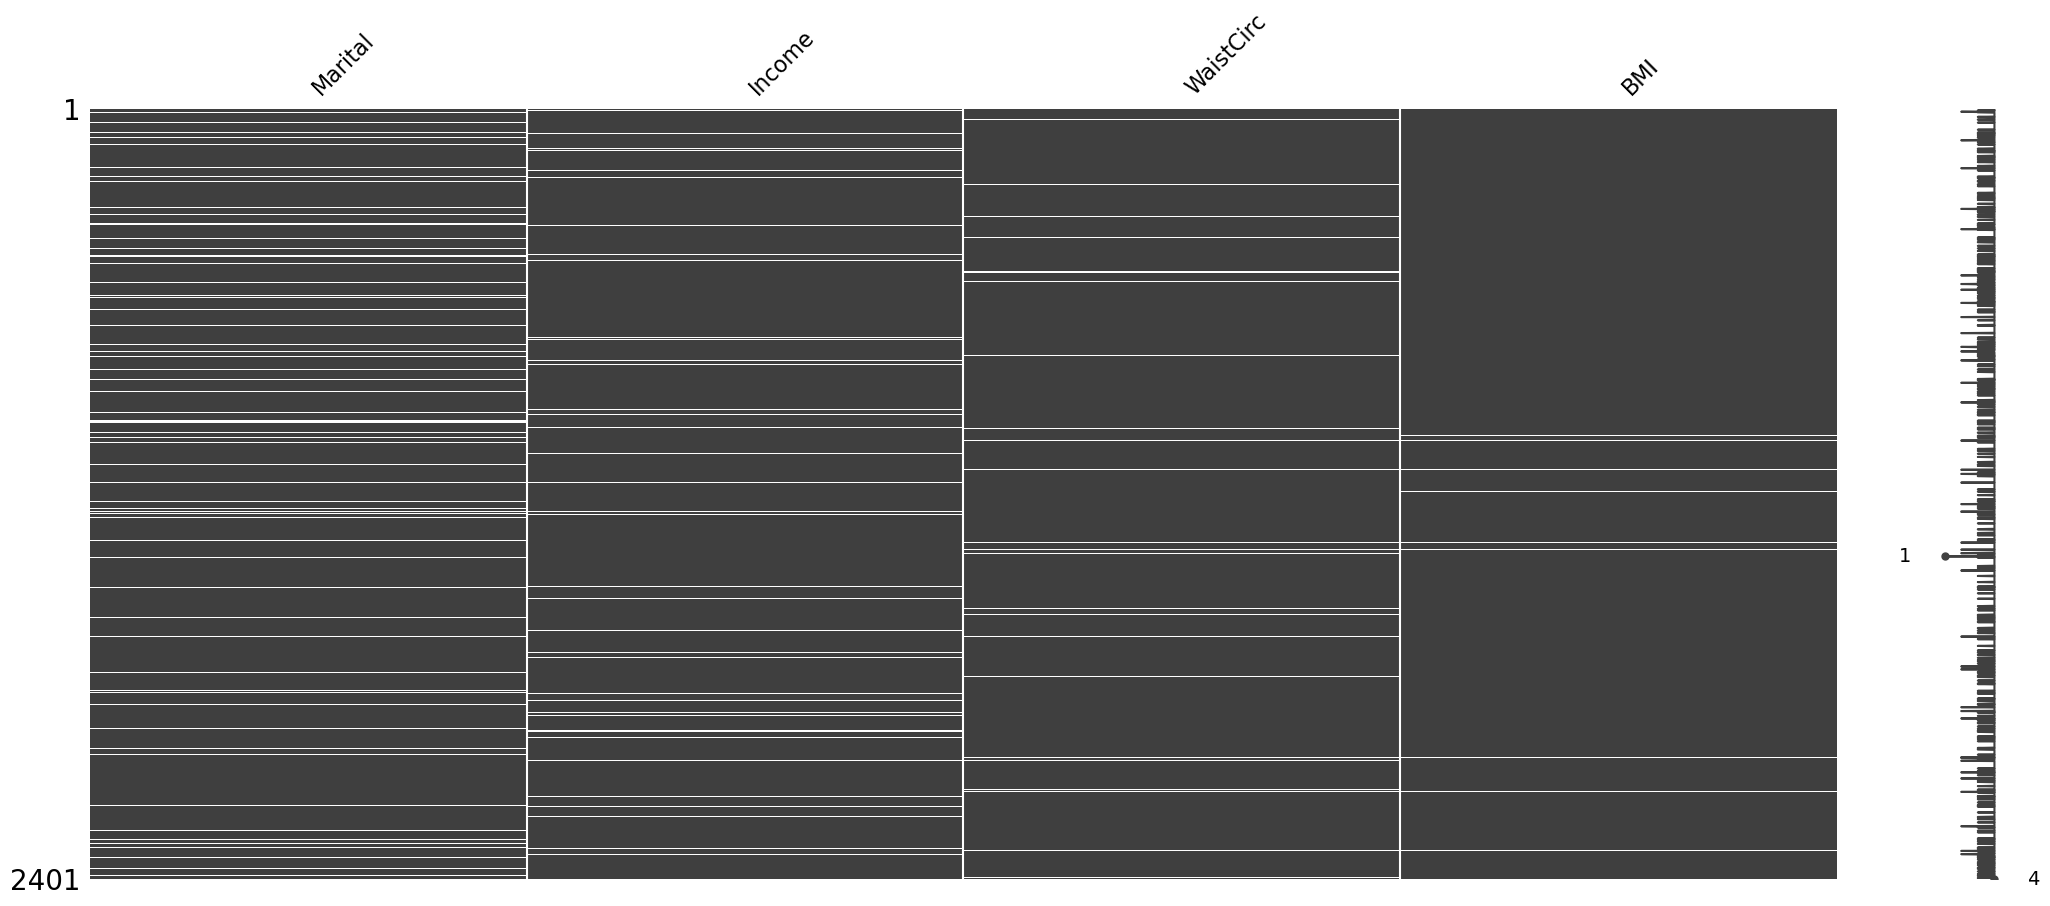

In [16]:
# looking at individulal missing sections
missingno.matrix(df[['Marital','Income','WaistCirc','BMI']]);

* ### My missing values are comming from Marital, Income, WaistCirc, and BMI

`Categorical Missing Values`

Marital

In [17]:
# Fill NaN values with the constant value 'Unknown'
df.Marital.fillna('Unknown',inplace=True)

In [18]:
# Looking at the value counts in Marital
df['Marital'].value_counts()

Married      1192
Single        498
Divorced      242
Unknown       208
Widowed       166
Separated      95
Name: Marital, dtype: int64

In [19]:
# Rechecking missing values in Marital
df['Marital'].isna().sum()

0

`Numeric Missing Values`

In [20]:
# Rechecking all missing values
df.isna().sum().sum()

228

In [21]:
# Display the sum of my missing values
df.isna().sum()

Age                    0
Sex                    0
Marital                0
Income               117
Race                   0
WaistCirc             85
BMI                   26
Albuminuria            0
UrAlbCr                0
UricAcid               0
BloodGlucose           0
HDL                    0
Triglycerides          0
MetabolicSyndrome      0
dtype: int64

Income, WaistCirc, BMI

In [22]:
#Imputing num_cols with mean
df['Income'] = df['Income'].fillna(df['Income'].mean())
df['WaistCirc'] = df['WaistCirc'].fillna(df['WaistCirc'].mean())
df['BMI'] = df['BMI'].fillna(df['BMI'].mean())

In [23]:
# Rechecking Missing Values
df.isna().sum().sum()

0

In [24]:
# Rechecking Missing columns
df.isna().sum()

Age                  0
Sex                  0
Marital              0
Income               0
Race                 0
WaistCirc            0
BMI                  0
Albuminuria          0
UrAlbCr              0
UricAcid             0
BloodGlucose         0
HDL                  0
Triglycerides        0
MetabolicSyndrome    0
dtype: int64

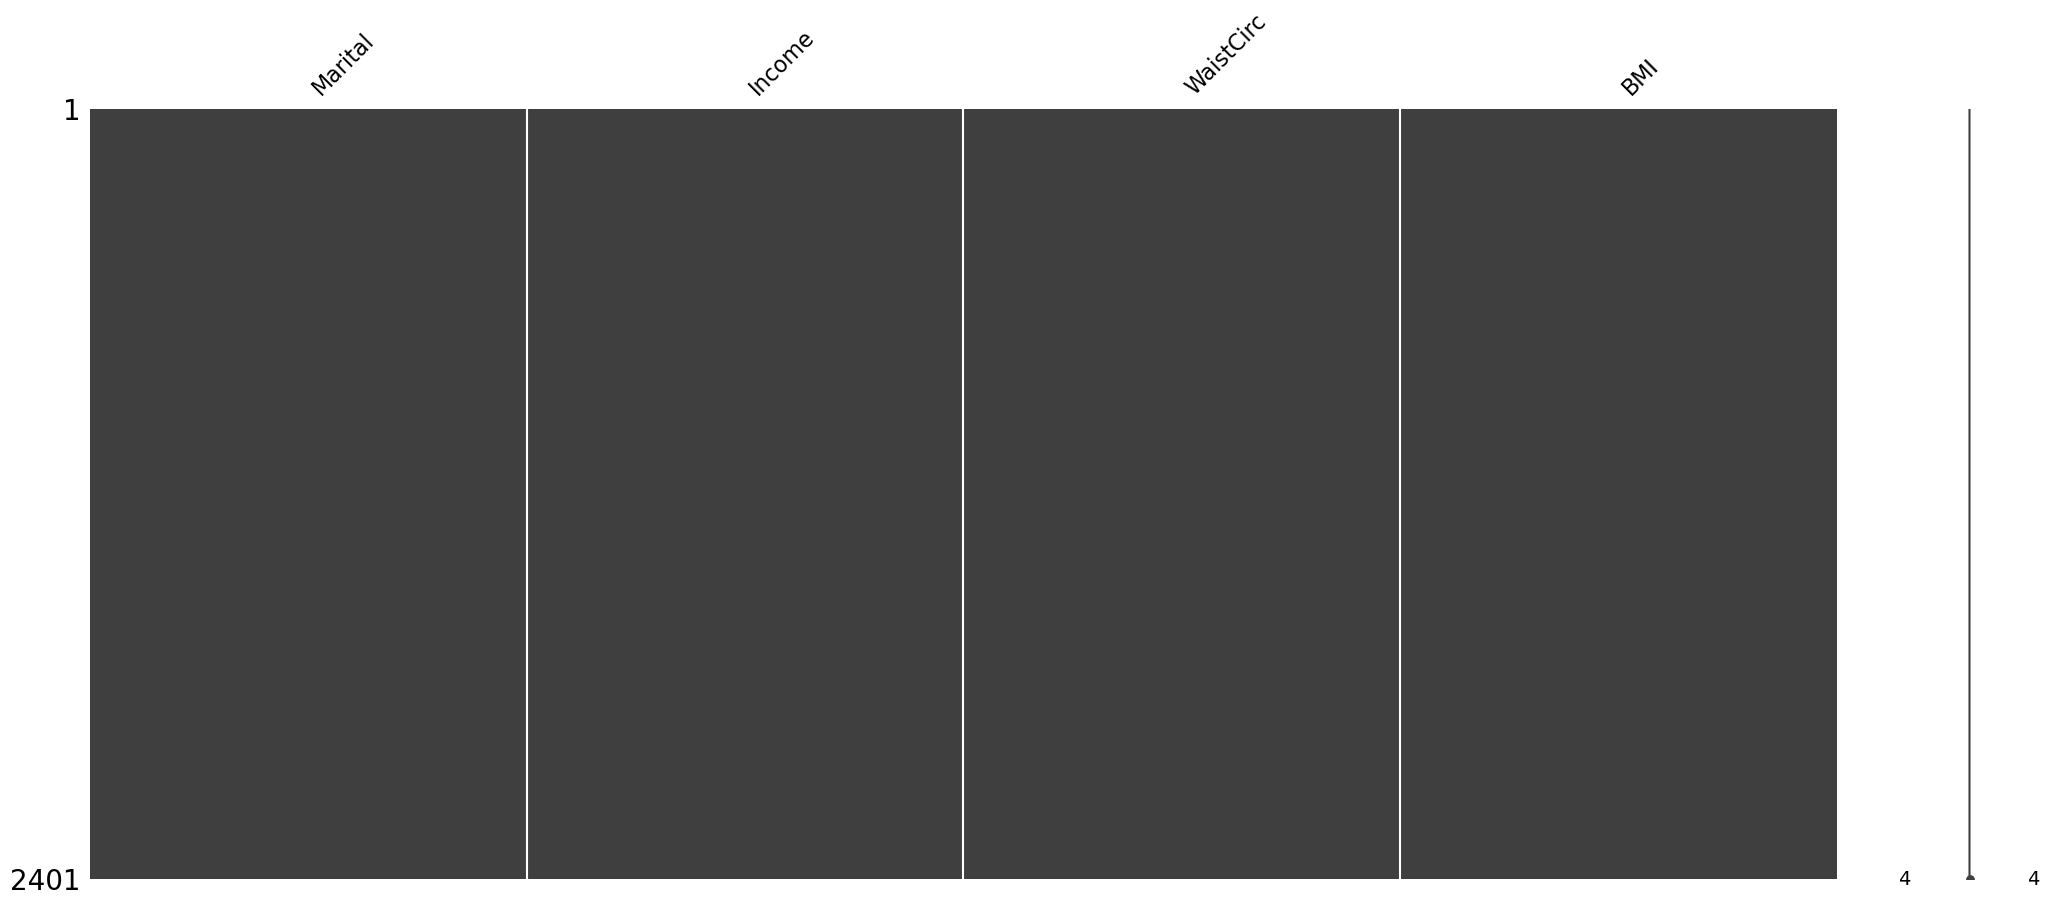

In [25]:
missingno.matrix(df[['Marital','Income','WaistCirc','BMI']]);

In [26]:
df.describe(include='object')

,Sex,Marital,Race,MetabolicSyndrome
count,2401,2401,2401,2401
unique,2,6,6,2
top,Female,Married,White,No MetSyn
freq,1211,1192,933,1579


In [27]:
# Taking a closer look at Sex column
df['Sex'].value_counts()

Female    1211
Male      1190
Name: Sex, dtype: int64

In [28]:
# Looking at Value caounts in Metabolic Syndrome
df['MetabolicSyndrome'].value_counts()

No MetSyn    1579
MetSyn        822
Name: MetabolicSyndrome, dtype: int64

In [29]:
# Sex and MetabolicSyndrome binary encoding
df['Sex'] = df['Sex'].map({'Male': 1, 'Female': 0})
df['MetabolicSyndrome'] = df['MetabolicSyndrome'].map({'MetSyn': 1, 'No MetSyn': 0})
df.head()

,Age,Sex,Marital,Income,Race,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome
seqn,,,,,,,,,,,,,,
62161,22,1,Single,8200.00000,White,81.0,23.3,0,3.88,4.9,92,41,84,0
62164,44,0,Married,4500.00000,White,80.1,23.2,0,8.55,4.5,82,28,56,0
62169,21,1,Single,800.00000,Asian,69.6,20.1,0,5.07,5.4,107,43,78,0
62172,43,0,Single,2000.00000,Black,120.4,33.3,0,5.22,5.0,104,73,141,0
62177,51,1,Married,4005.25394,Asian,81.1,20.1,0,8.13,5.0,95,43,126,0


In [30]:
# Looking over the stats
df.describe(exclude='object')

,Age,Sex,Income,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome
count,2401.000000,2401.000000,2401.000000,2401.000000,2401.000000,2401.000000,2401.000000,2401.000000,2401.000000,2401.000000,2401.000000,2401.000000
mean,48.691795,0.495627,4005.253940,98.307254,28.702189,0.154102,43.626131,5.489046,108.247813,53.369429,128.125364,0.342357
std,17.632852,0.500085,2881.128031,15.962233,6.626057,0.422780,258.272829,1.439358,34.820657,15.185537,95.322477,0.474597
min,20.000000,0.000000,300.000000,56.200000,13.400000,0.000000,1.400000,1.800000,39.000000,14.000000,26.000000,0.000000
25%,34.000000,0.000000,1600.000000,87.000000,24.000000,0.000000,4.450000,4.500000,92.000000,43.000000,75.000000,0.000000
50%,48.000000,0.000000,3500.000000,97.500000,27.800000,0.000000,7.070000,5.400000,99.000000,51.000000,103.000000,0.000000
75%,63.000000,1.000000,6200.000000,107.200000,32.000000,0.000000,13.690000,6.400000,110.000000,62.000000,150.000000,1.000000
max,80.000000,1.000000,9000.000000,176.000000,68.700000,2.000000,5928.000000,11.300000,382.000000,156.000000,1562.000000,1.000000


# `Exploratory Visualizations`
* Creating explorator visualizations to understand your data and search for trends.

In [31]:
# Get correlations
corr = df.corr(numeric_only = True)
corr.round(2)

,Age,Sex,Income,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome
Age,1.00,0.01,-0.01,0.22,0.08,0.23,0.12,0.15,0.24,0.08,0.07,0.25
Sex,0.01,1.00,0.03,0.12,-0.05,0.02,0.01,0.41,0.09,-0.32,0.13,0.02
Income,-0.01,0.03,1.00,-0.06,-0.08,-0.10,-0.05,0.01,-0.09,0.08,-0.04,-0.08
WaistCirc,0.22,0.12,-0.06,1.00,0.88,0.12,0.04,0.35,0.25,-0.34,0.23,0.49
BMI,0.08,-0.05,-0.08,0.88,1.00,0.08,0.04,0.27,0.21,-0.29,0.16,0.43
Albuminuria,0.23,0.02,-0.10,0.12,0.08,1.00,0.54,0.18,0.20,-0.02,0.11,0.16
UrAlbCr,0.12,0.01,-0.05,0.04,0.04,0.54,1.00,0.13,0.11,0.00,0.08,0.09
UricAcid,0.15,0.41,0.01,0.35,0.27,0.18,0.13,1.00,0.06,-0.25,0.21,0.25
BloodGlucose,0.24,0.09,-0.09,0.25,0.21,0.20,0.11,0.06,1.00,-0.21,0.27,0.36
HDL,0.08,-0.32,0.08,-0.34,-0.29,-0.02,0.00,-0.25,-0.21,1.00,-0.39,-0.37


<Axes: >

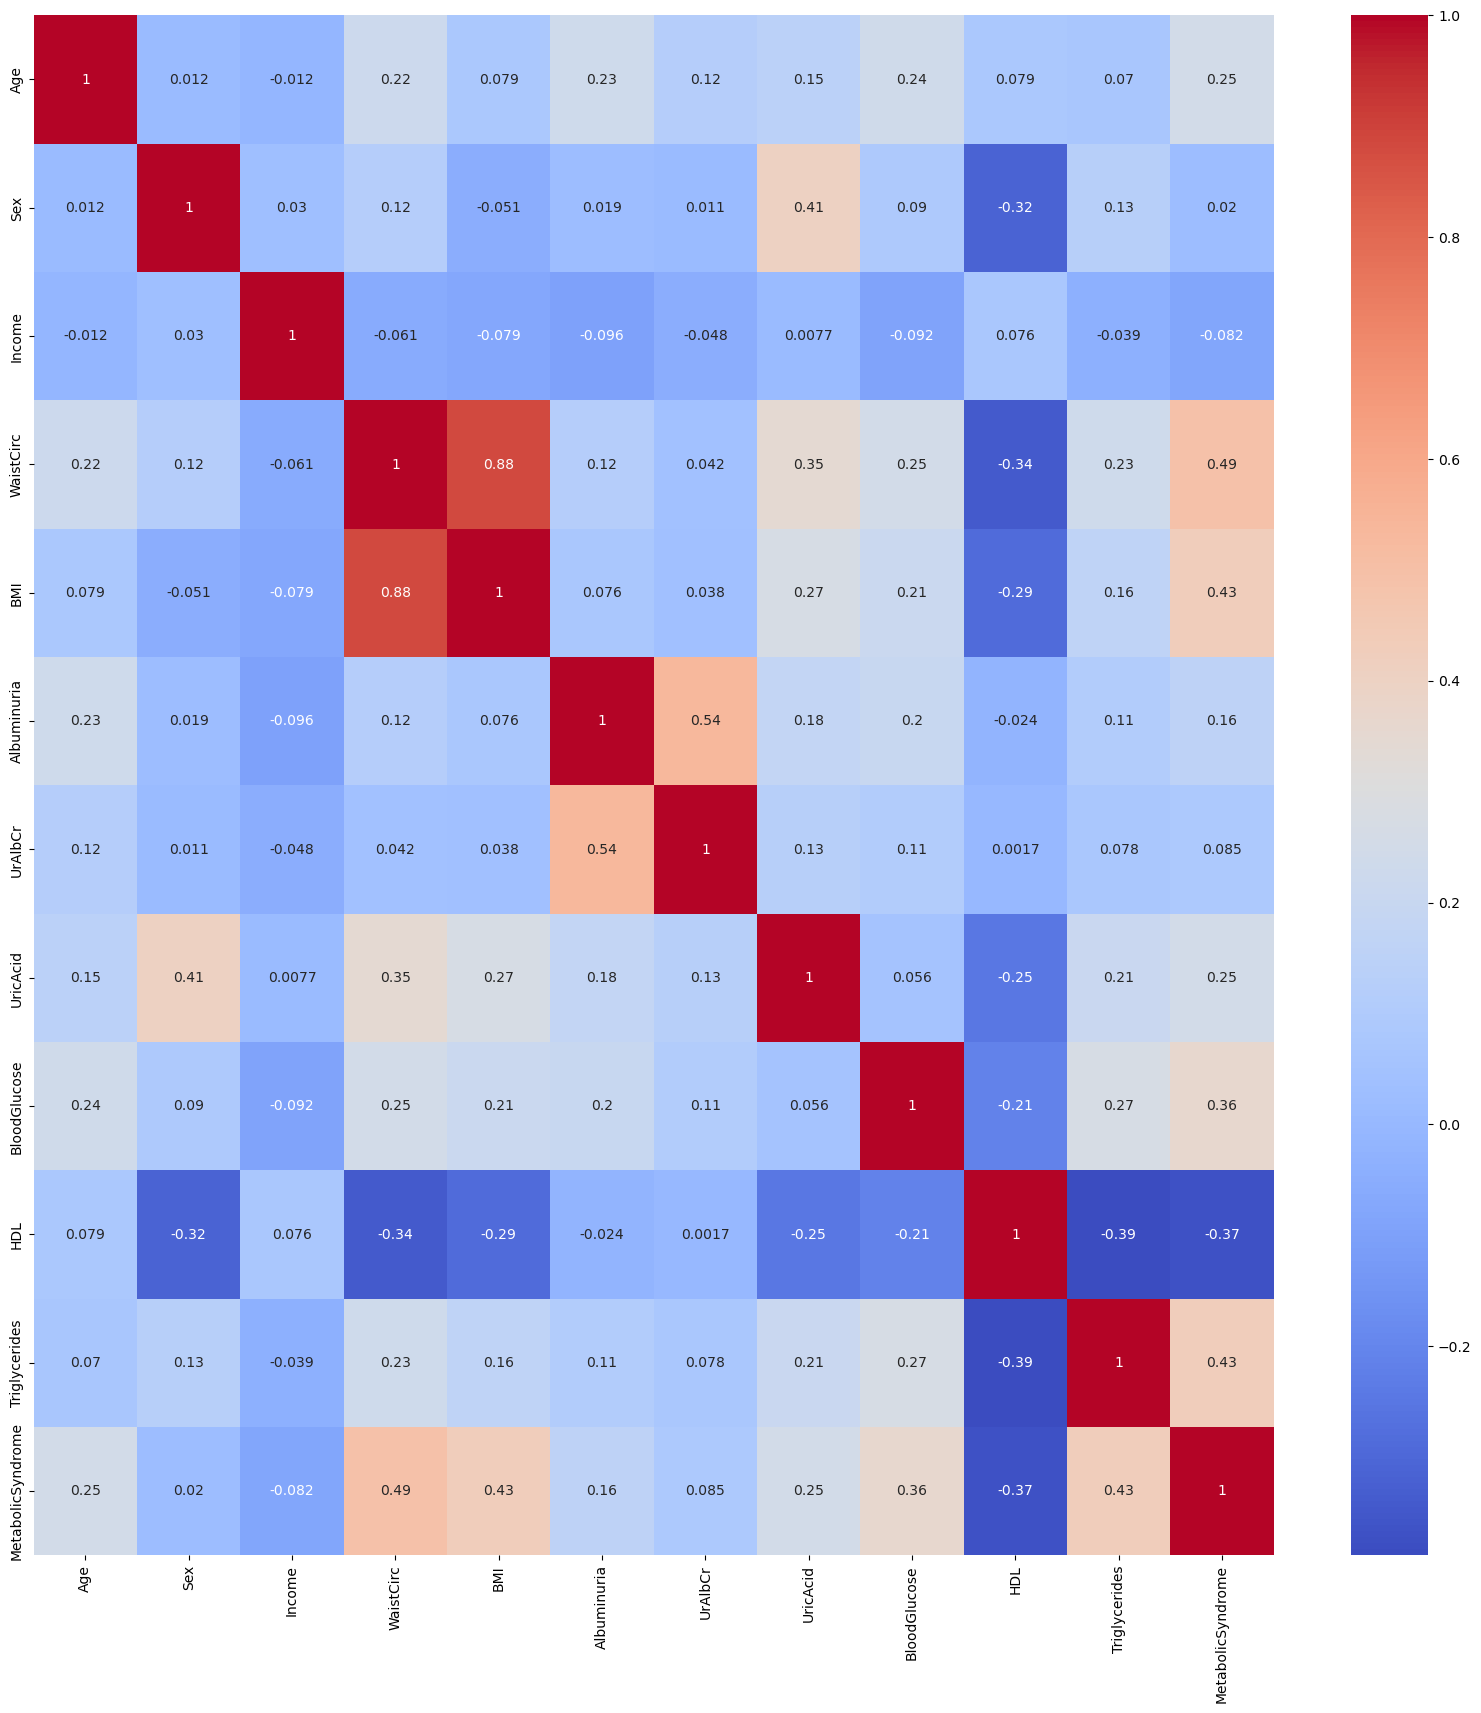

In [38]:
# Create a fig, ax with a figsize argument
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(corr, cmap = 'coolwarm', annot = True, ax=ax)

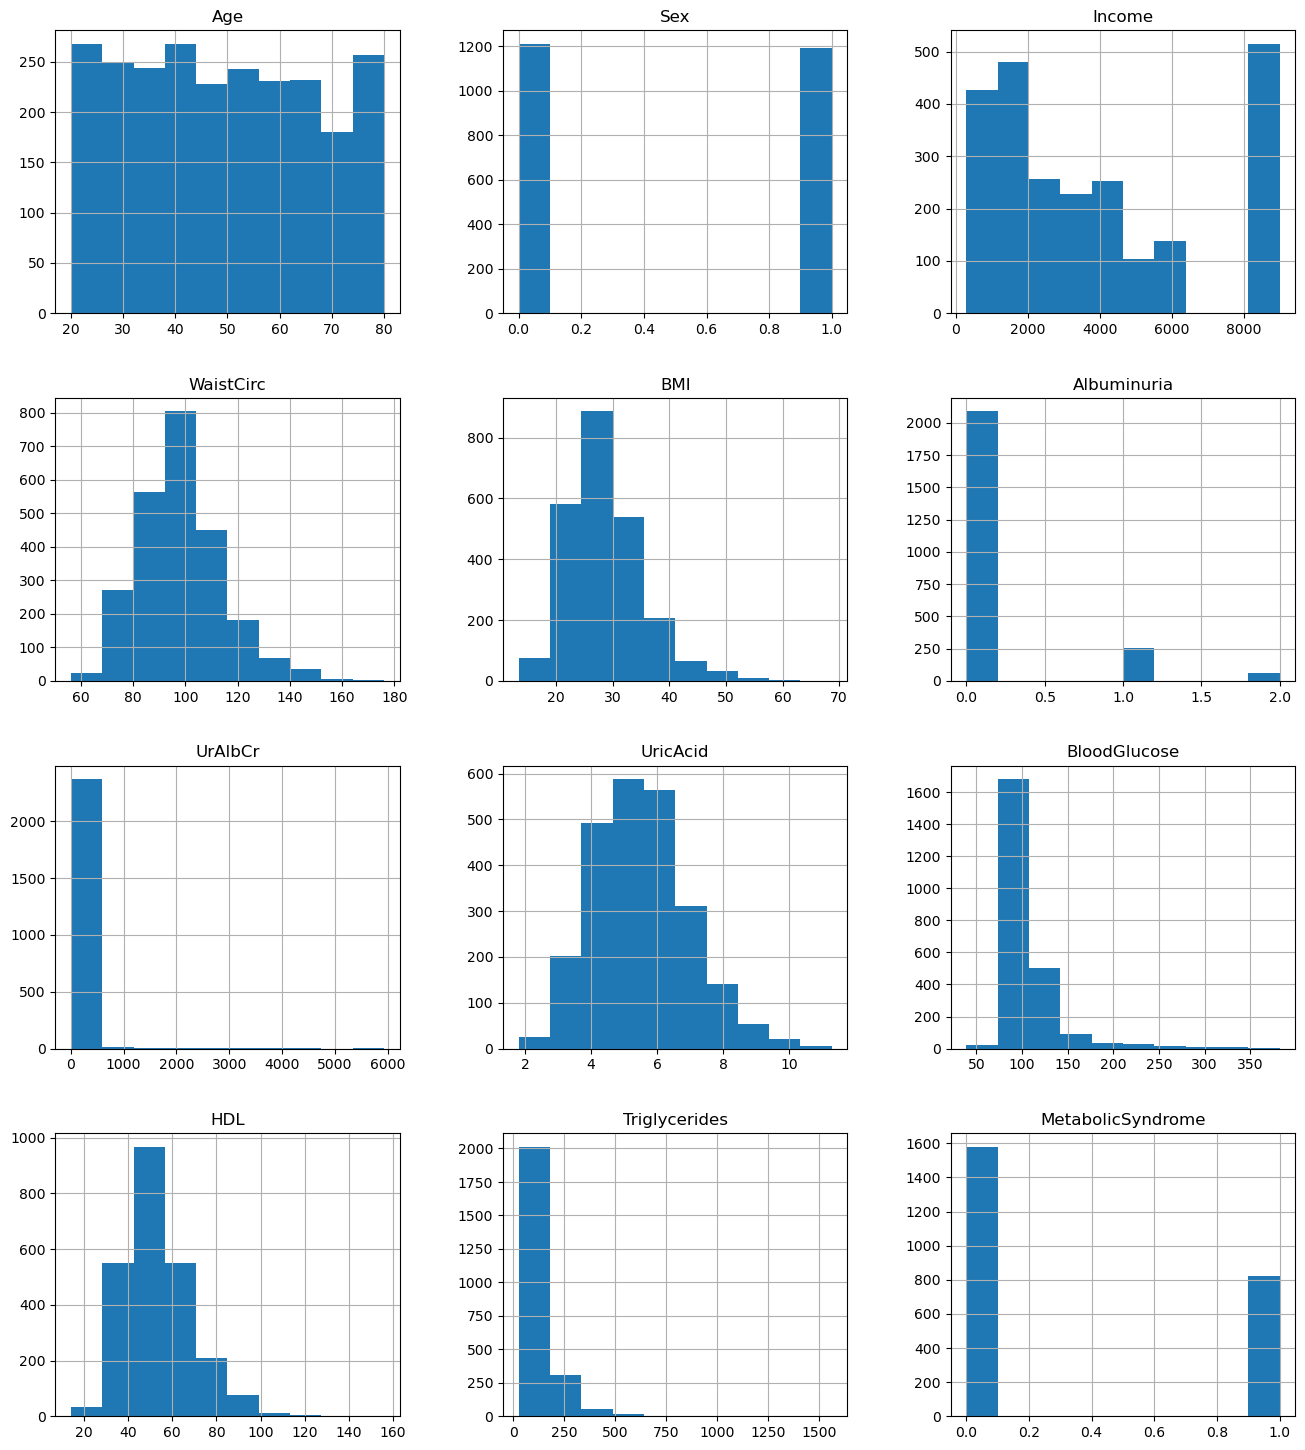

In [32]:
# Creating a visual plot 
df.hist(figsize=(16,18));

Marital count plot 



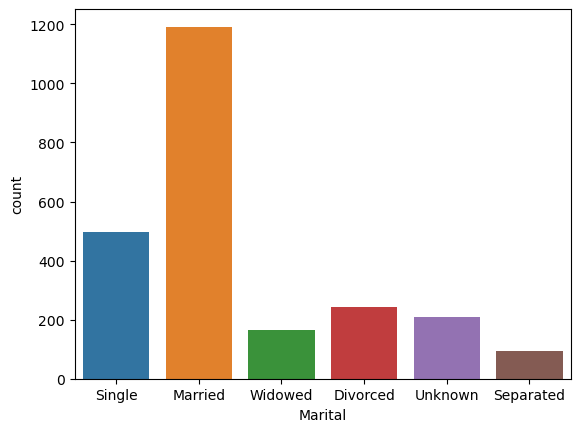

Race count plot 



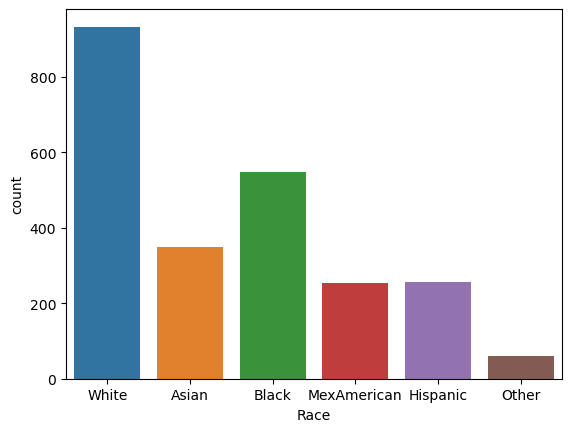

In [39]:
for col in df.select_dtypes('object').columns:
    print(col +' count plot \n') 
    sns.countplot(x =col, data =df)
    plt.show()

In [41]:
# Check how many samples of each class are present
df['MetabolicSyndrome'].value_counts(normalize=False)

0    1579
1     822
Name: MetabolicSyndrome, dtype: int64

In [42]:
# Check how many samples of each class are present
df['MetabolicSyndrome'].value_counts(normalize=True)

0    0.657643
1    0.342357
Name: MetabolicSyndrome, dtype: float64

# `Choose a model`
* ## Preprocess data

In [43]:
# Split X and y, we are predicting Metabolic Syndrometarget = 'MetabolicSyndrome'
X = df.drop(columns=[target]).copy()
y = df[target].copy()

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [45]:
# Check for class balance of target
y_train.value_counts(1)

0    0.657778
1    0.342222
Name: MetabolicSyndrome, dtype: float64

In [46]:
X_train.shape

(1800, 13)

In [47]:
X_test.shape

(601, 13)

In [48]:
X_train.dtypes

Age                int64
Sex                int64
Marital           object
Income           float64
Race              object
WaistCirc        float64
BMI              float64
Albuminuria        int64
UrAlbCr          float64
UricAcid         float64
BloodGlucose       int64
HDL                int64
Triglycerides      int64
dtype: object

In [49]:
cat_cols = ['Sex', 'Marital','Race']
num_cols = ['Age', 'Income','WaistCirc','BMI','Albuminuria','UrAlbCr','UricAcid','BloodGlucose','HDL','Triglycerides']

In [50]:
# Categorical Pipeline / Tuple
# Using value 'Undisclosed' to fill in null values (all in 'Marital')
impute_missing = SimpleImputer(strategy='constant',fill_value='Missing')
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
scaler = StandardScaler()

nom_pipe = make_pipeline(impute_missing, ohe_encoder, scaler)
nom_pipe

# Nominal Tuple
nom_tuple = ('categorical', nom_pipe, cat_cols)

nom_tuple

('categorical',
 Pipeline(steps=[('simpleimputer',
                  SimpleImputer(fill_value='Missing', strategy='constant')),
                 ('onehotencoder',
                  OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
                 ('standardscaler', StandardScaler())]),
 ['Sex', 'Marital', 'Race'])

In [51]:
# PREPROCESSING PIPELINE FOR NUMERIC DATA
# Save list of column names
print("Numeric Columns:", num_cols)

# Transformers
median_imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

# Make a numeric preprocessing pipeline
num_pipe = make_pipeline(median_imputer, scaler)
# Making a numeric tuple for ColumnTransformer
num_tuple = ('numeric', num_pipe, num_cols)
num_tuple

Numeric Columns: ['Age', 'Income', 'WaistCirc', 'BMI', 'Albuminuria', 'UrAlbCr', 'UricAcid', 'BloodGlucose', 'HDL', 'Triglycerides']


('numeric',
 Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                 ('standardscaler', StandardScaler())]),
 ['Age',
  'Income',
  'WaistCirc',
  'BMI',
  'Albuminuria',
  'UrAlbCr',
  'UricAcid',
  'BloodGlucose',
  'HDL',
  'Triglycerides'])

In [52]:
# Create the preprocessor using make_column_transformer
preprocessor = ColumnTransformer([num_tuple, nom_tuple],
                                 verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Age', 'Income', 'WaistCirc', 'BMI',
                                  'Albuminuria', 'UrAlbCr', 'UricAcid',
                                  'BloodGlucose', 'HDL', 'Triglycerides']),
                                ('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='Missing',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False)),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Sex', 'Marital', 'Race'])],
                  verbose_feature_names_out=False)

In [53]:
# Fitting column transformer and run get_feature_names_out
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()
feature_names

array(['Age', 'Income', 'WaistCirc', 'BMI', 'Albuminuria', 'UrAlbCr',
       'UricAcid', 'BloodGlucose', 'HDL', 'Triglycerides', 'Sex_0',
       'Sex_1', 'Marital_Divorced', 'Marital_Married',
       'Marital_Separated', 'Marital_Single', 'Marital_Unknown',
       'Marital_Widowed', 'Race_Asian', 'Race_Black', 'Race_Hispanic',
       'Race_MexAmerican', 'Race_Other', 'Race_White'], dtype=object)

In [54]:
X_train_tf = pd.DataFrame(preprocessor.transform(X_train),
                           columns = feature_names, index = X_train.index)
X_train_tf.head()

,Age,Income,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,Sex_0,Sex_1,Marital_Divorced,Marital_Married,Marital_Separated,Marital_Single,Marital_Unknown,Marital_Widowed,Race_Asian,Race_Black,Race_Hispanic,Race_MexAmerican,Race_Other,Race_White
seqn,,,,,,,,,,,,,,,,,,,,,,,,
67675,1.013097,0.175844,-0.162812,-0.668321,-0.365911,-0.088157,-0.769430,-0.254298,0.933237,-0.151196,-1.017939,1.017939,-0.351562,1.015678,-0.201153,-0.519031,-0.304789,-0.256358,-0.417335,-0.530225,-0.342518,2.885555,-0.160128,-0.808018
65978,0.495836,-0.515066,1.169888,0.849670,2.011850,-0.019433,1.059383,0.218478,-1.423044,0.189057,-1.017939,1.017939,-0.351562,-0.984564,-0.201153,1.926666,-0.304789,-0.256358,-0.417335,-0.530225,-0.342518,-0.346554,-0.160128,1.237597
68502,-1.228367,-0.825976,0.040795,0.023041,-0.365911,-0.160450,0.567010,-0.697525,-0.682499,-0.481441,-1.017939,1.017939,-0.351562,-0.984564,-0.201153,1.926666,-0.304789,-0.256358,-0.417335,1.885991,-0.342518,-0.346554,-0.160128,-0.808018
62397,1.242991,-0.860522,1.657311,1.781507,-0.365911,-0.149655,-0.488074,1.075385,-0.547854,0.189057,0.982377,-0.982377,-0.351562,-0.984564,-0.201153,-0.519031,-0.304789,3.900797,-0.417335,-0.530225,-0.342518,2.885555,-0.160128,-0.808018
66594,0.725730,-1.033249,1.046490,0.729433,2.011850,-0.035924,-0.136379,1.400418,-1.086433,0.219079,-1.017939,1.017939,2.844452,-0.984564,-0.201153,-0.519031,-0.304789,-0.256358,-0.417335,-0.530225,-0.342518,2.885555,-0.160128,-0.808018


In [55]:
X_test_tf = pd.DataFrame(preprocessor.transform(X_test),
                           columns = feature_names, index = X_test.index)
X_test_tf.head()

,Age,Income,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,Sex_0,Sex_1,Marital_Divorced,Marital_Married,Marital_Separated,Marital_Single,Marital_Unknown,Marital_Widowed,Race_Asian,Race_Black,Race_Hispanic,Race_MexAmerican,Race_Other,Race_White
seqn,,,,,,,,,,,,,,,,,,,,,,,,
66389,0.380889,-0.791431,1.379665,0.263515,-0.365911,-0.160705,0.778027,-0.520234,-1.423044,2.080462,-1.017939,1.017939,-0.351562,1.015678,-0.201153,-0.519031,-0.304789,-0.256358,-0.417335,-0.530225,-0.342518,-0.346554,-0.160128,1.237597
67367,-0.941000,-0.515066,-0.693424,-0.578144,-0.365911,-0.125685,-1.191463,-0.254298,0.461981,0.229087,0.982377,-0.982377,-0.351562,1.015678,-0.201153,-0.519031,-0.304789,-0.256358,-0.417335,-0.530225,-0.342518,2.885555,-0.160128,-0.808018
71244,0.898150,1.730392,-0.471307,-0.487966,-0.365911,-0.151737,-0.839769,-0.017910,0.731270,-0.281292,0.982377,-0.982377,2.844452,-0.984564,-0.201153,-0.519031,-0.304789,-0.256358,-0.417335,-0.530225,-0.342518,-0.346554,-0.160128,1.237597
68091,1.472884,-0.860522,1.034150,1.345648,-0.365911,-0.092492,0.004298,2.464164,-0.817143,1.520046,0.982377,-0.982377,-0.351562,-0.984564,-0.201153,-0.519031,-0.304789,3.900797,-0.417335,-0.530225,-0.342518,2.885555,-0.160128,-0.808018
69141,1.817725,-0.515066,0.608427,-0.067137,2.011850,0.241605,-0.206718,1.016288,1.135204,-0.461426,-1.017939,1.017939,-0.351562,1.015678,-0.201153,-0.519031,-0.304789,-0.256358,-0.417335,1.885991,-0.342518,-0.346554,-0.160128,-0.808018


In [56]:
# Confirming the first 3 rows index in y_test matches X_test_df
y_test.head()

seqn
66389    1
67367    0
71244    0
68091    1
69141    1
Name: MetabolicSyndrome, dtype: int64

* ## Fit and evaluate a default model

In [59]:
# Define LogReg model pipeline
X_train_rf = preprocessor.fit_transform(X_train)
X_test_rf = preprocessor.transform(X_test)

# Create an instance of the model
rfc = RandomForestClassifier()
rfc.fit(X_train_tf, y_train)

RandomForestClassifier()

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1184
           1       1.00      1.00      1.00       616

    accuracy                           1.00      1800
   macro avg       1.00      1.00      1.00      1800
weighted avg       1.00      1.00      1.00      1800



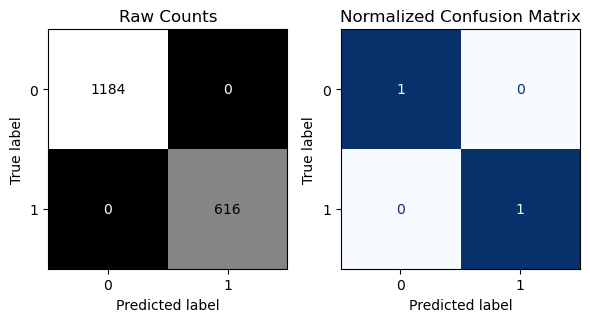


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.93      0.92       395
           1       0.86      0.81      0.83       206

    accuracy                           0.89       601
   macro avg       0.88      0.87      0.88       601
weighted avg       0.89      0.89      0.89       601



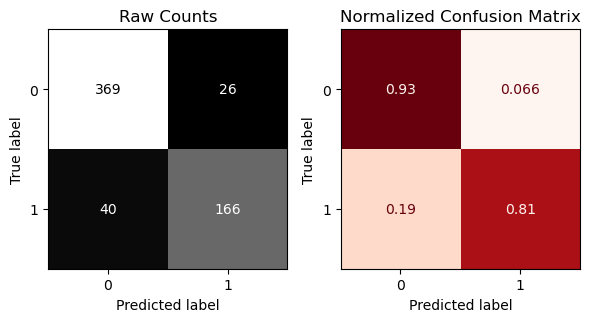

In [60]:
evaluate_classification(rfc, X_train_rf, y_train, X_test_rf, y_test)

* ## Extract and visualize the top 10 features using permutation importance
    * (from Intro to ML Week 4)

In [62]:
from imblearn.over_sampling import RandomOverSampler
over_sampler = RandomOverSampler()
X_train_ov, y_train_ov = over_sampler.fit_resample(X_train_tf, y_train)
y_train_ov.value_counts()

0    1184
1    1184
Name: MetabolicSyndrome, dtype: int64

In [63]:
# Create an instance of the model
rfc_over = RandomForestClassifier()
rfc_over.fit(X_train_ov, y_train_ov)

RandomForestClassifier()

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1184
           1       1.00      1.00      1.00      1184

    accuracy                           1.00      2368
   macro avg       1.00      1.00      1.00      2368
weighted avg       1.00      1.00      1.00      2368



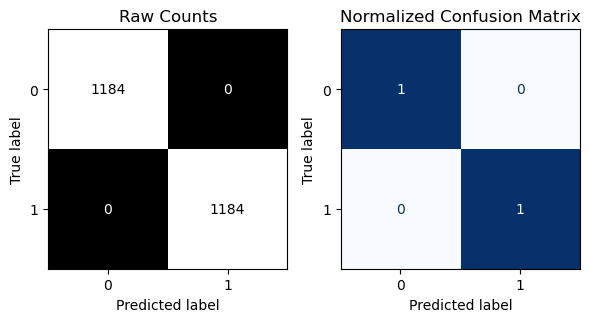


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       395
           1       0.83      0.83      0.83       206

    accuracy                           0.89       601
   macro avg       0.87      0.87      0.87       601
weighted avg       0.89      0.89      0.89       601



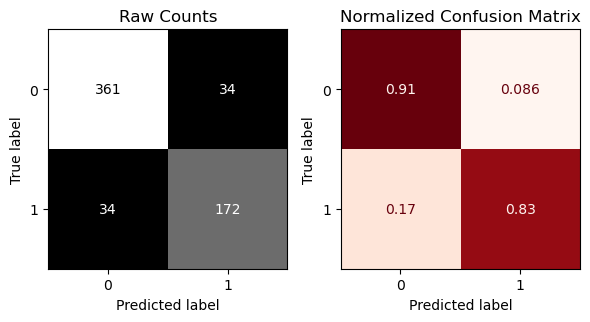

In [64]:
evaluate_classification(rfc_over, X_train_ov, y_train_ov, X_test_tf, y_test)

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1184
           1       1.00      1.00      1.00       616

    accuracy                           1.00      1800
   macro avg       1.00      1.00      1.00      1800
weighted avg       1.00      1.00      1.00      1800



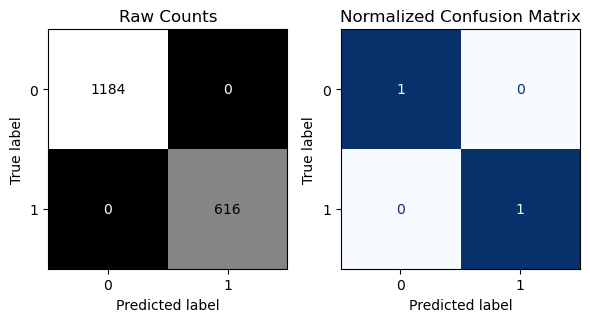


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.93      0.92       395
           1       0.86      0.81      0.83       206

    accuracy                           0.89       601
   macro avg       0.88      0.87      0.88       601
weighted avg       0.89      0.89      0.89       601



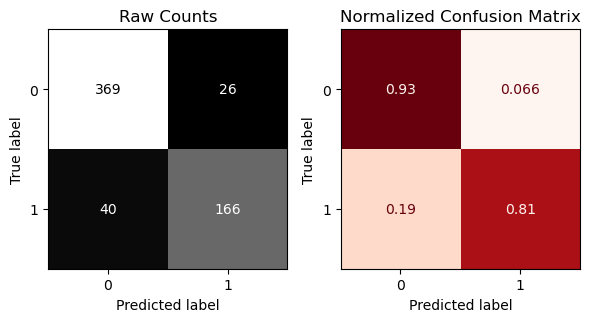

In [65]:
evaluate_classification(rfc, X_train_rf, y_train, X_test_rf, y_test)

* ## Add your observations in a Markdown:
    * ### Do these features make sense based on the business case?

* ## `Create Explanatory Visualizations for the most important features`
    *  ### Select 2 out of the top 10 features from your permutation importances and produce explanatory visualizations showing the relationship between the feature and the target.
    *  ### The purpose is to demonstrate key trends you found that will be of interest to a stakeholder.

In [66]:
from sklearn.inspection import permutation_importance

In [67]:
# Obtain feature importances from the fit model
rfc.feature_importances_

array([0.05274316, 0.03245499, 0.14112208, 0.10975002, 0.00597274,
       0.05661016, 0.04458052, 0.17912552, 0.10678286, 0.18854519,
       0.01335574, 0.01247563, 0.00508432, 0.00715841, 0.00237402,
       0.0050422 , 0.00341547, 0.00406587, 0.0048067 , 0.00582016,
       0.00562437, 0.00417838, 0.00222408, 0.00668743])

In [68]:
# Checking the number of feature importances matches the # of columns
print(len(rfc.feature_importances_))
print(len(X_train_tf.columns))
len(rfc.feature_importances_) == len(X_train_tf.columns)

24
24


True

## `Explanatory Visualization 1`

In [69]:
def get_importances(model, feature_names=None,name='Feature Importance',
                   sort=False, ascending=True):
    
    ## checking for feature names
    if feature_names == None:
        feature_names = model.feature_names_in_
        
    ## Saving the feature importances
    importances = pd.Series(model.feature_importances_, index= feature_names,
                           name=name)
    
    # sort importances
    if sort == True:
        importances = importances.sort_values(ascending=ascending)
        
    return importances

In [70]:
importances = get_importances(rfc,sort=True,ascending=False)
importances

Triglycerides        0.188545
BloodGlucose         0.179126
WaistCirc            0.141122
BMI                  0.109750
HDL                  0.106783
UrAlbCr              0.056610
Age                  0.052743
UricAcid             0.044581
Income               0.032455
Sex_0                0.013356
Sex_1                0.012476
Marital_Married      0.007158
Race_White           0.006687
Albuminuria          0.005973
Race_Black           0.005820
Race_Hispanic        0.005624
Marital_Divorced     0.005084
Marital_Single       0.005042
Race_Asian           0.004807
Race_MexAmerican     0.004178
Marital_Widowed      0.004066
Marital_Unknown      0.003415
Marital_Separated    0.002374
Race_Other           0.002224
Name: Feature Importance, dtype: float64

In [71]:
def plot_importance(importances, top_n=None,  figsize=(8,6)):
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Importance',
            ylabel='Feature Names',
            title=title)
    ## return ax in case want to continue to update/modify figure
    return ax

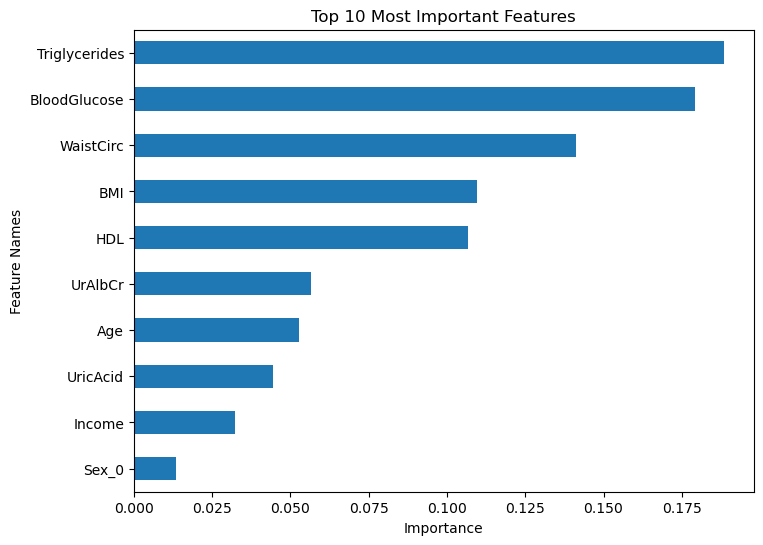

In [72]:
# testing our function
importances = get_importances(rfc,sort=True,ascending=False,
                              name="RandomForest Importances")
plot_importance(importances,top_n=10);

## `Explanatory Visualization 2`

In [73]:
# Permutation importance takes a fit model and the test data.
r = permutation_importance(rfc, X_test_tf, y_test,n_repeats =5)
r.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [74]:
# Making the mean importances into a series
permutation_importances = pd.Series(r['importances_mean'],index=X_test_tf.columns,
                           name = 'permutation importance')
permutation_importances = permutation_importances.sort_values(ascending=False)
permutation_importances

BloodGlucose         0.077870
Triglycerides        0.073544
WaistCirc            0.046922
HDL                  0.034609
BMI                  0.021963
UrAlbCr              0.015973
Sex_1                0.011980
Age                  0.011647
Sex_0                0.007654
Race_Black           0.003993
Albuminuria          0.003993
UricAcid             0.003993
Marital_Divorced     0.003661
Marital_Single       0.001664
Marital_Widowed      0.001664
Race_White           0.001664
Marital_Separated    0.000333
Marital_Unknown      0.000333
Race_MexAmerican     0.000000
Race_Other           0.000000
Race_Hispanic       -0.000666
Marital_Married     -0.000998
Race_Asian          -0.001331
Income              -0.003993
Name: permutation importance, dtype: float64

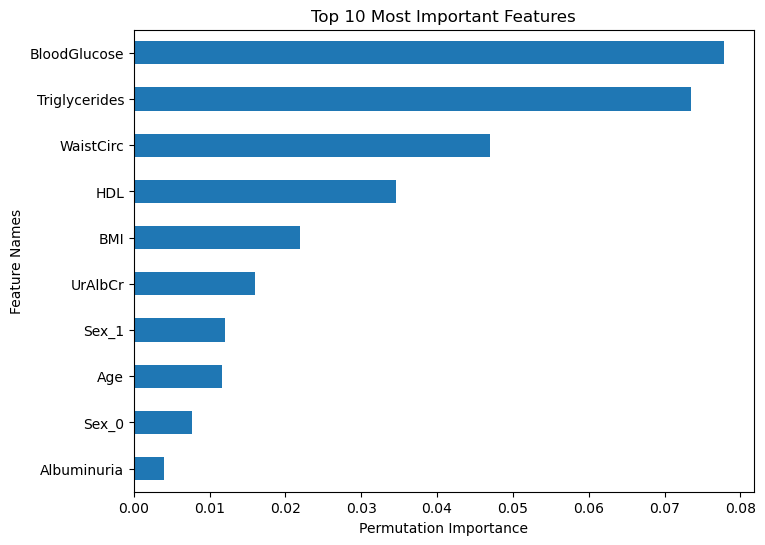

In [75]:
ax = plot_importance(permutation_importances,top_n=10)
ax.set(xlabel='Permutation Importance');

In [76]:
def get_color_dict(importances, color_rest='#006ba4' , color_top='green',
                    top_n=7):
    ## color -coding top 5 bars
    highlight_feats = importances.sort_values(ascending=True).tail(top_n).index
    colors_dict = {col: color_top if col in highlight_feats else color_rest for col in importances.index}
    return colors_dict

In [77]:
colors_top7 = get_color_dict(importances, top_n=7)
colors_top7

{'Triglycerides': 'green',
 'BloodGlucose': 'green',
 'WaistCirc': 'green',
 'BMI': 'green',
 'HDL': 'green',
 'UrAlbCr': 'green',
 'Age': 'green',
 'UricAcid': '#006ba4',
 'Income': '#006ba4',
 'Sex_0': '#006ba4',
 'Sex_1': '#006ba4',
 'Marital_Married': '#006ba4',
 'Race_White': '#006ba4',
 'Albuminuria': '#006ba4',
 'Race_Black': '#006ba4',
 'Race_Hispanic': '#006ba4',
 'Marital_Divorced': '#006ba4',
 'Marital_Single': '#006ba4',
 'Race_Asian': '#006ba4',
 'Race_MexAmerican': '#006ba4',
 'Marital_Widowed': '#006ba4',
 'Marital_Unknown': '#006ba4',
 'Marital_Separated': '#006ba4',
 'Race_Other': '#006ba4'}

In [79]:
def plot_importance_color_ax(importances, top_n=None,  figsize=(8,6), 
                          color_dict=None, ax=None):
    
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## create plot with colors, if provided
    if color_dict is not None:
        ## Getting color list and saving to plot_kws
        colors = plot_vals.index.map(color_dict)
        ax = plot_vals.plot(kind='barh', figsize=figsize, color=colors, ax=ax)
        
    else:
        ## create plot without colors, if not provided
        ax = plot_vals.plot(kind='barh', figsize=figsize, ax=ax)
        
    # set titles and axis labels
    ax.set(xlabel='Importance', 
           ylabel='Feature Names', 
           title=title)
    
    ## return ax in case want to continue to update/modify figure
    return ax

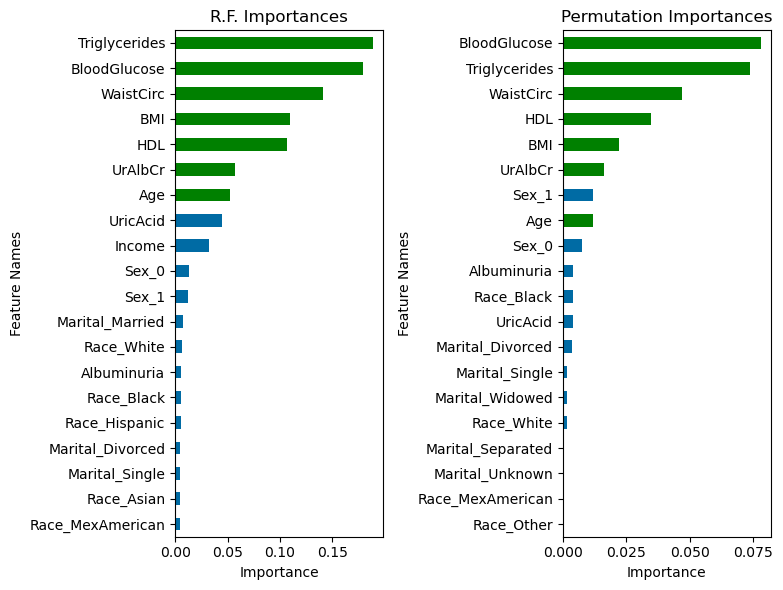

In [80]:
fig, axes = plt.subplots(ncols=2, figsize=(20,8))
n = 20 # setting the # of features to use for both subplots
plot_importance_color_ax(importances, top_n=n, ax=axes[0],
                         color_dict= colors_top7)
plot_importance_color_ax(permutation_importances, top_n=n, ax=axes[1],
                         color_dict=colors_top7)
axes[0].set(title='R.F. Importances')
axes[1].set(title='Permutation Importances')
fig.tight_layout()

Triglycerides and Blood Gucose are the higest on both graphs, URAlbCr is high the RF which can be signs of metabolic syndrome however so can many other factors that are high.

## `1. These visuals should be reporting-quality with titles, labels, and a short explanation of the trend.` 
* ### Explain in a text cell the insight associated with each visual.
    * Both of these visualizations should be easily understood by a non-technical audience
        * (Neither of these should be histograms, boxplots, or correlation plots).
## `2. These will be added to your readme in part 4`

## `Explanatory Visualization 1`

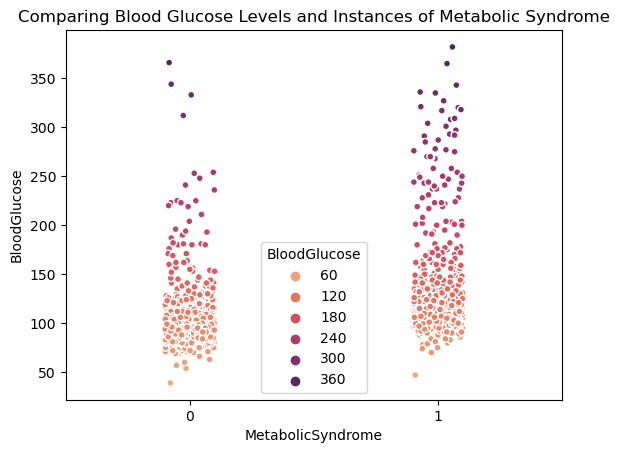

In [82]:
sns.stripplot(data=df, x='MetabolicSyndrome',y='BloodGlucose', hue='BloodGlucose', palette='flare', 
              edgecolor='white', linewidth=1).set(title="Comparing Blood Glucose Levels and Instances of Metabolic Syndrome");


## `Explanatory Visualization 2`

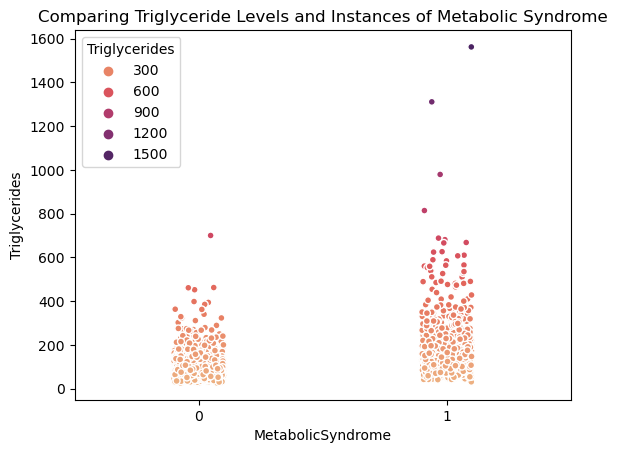

In [85]:
sns.stripplot(data=df, x='MetabolicSyndrome',y='Triglycerides', hue='Triglycerides', 
              palette='flare', edgecolor='white', 
              linewidth=1).set(title="Comparing Triglyceride Levels and Instances of Metabolic Syndrome");